# DBSCAN
-------

In [36]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score

In [37]:
df = pd.read_csv('wholesale_customers_data.csv')
print(df.shape)
print(df.columns)
df.head()

(440, 8)
Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [38]:
df['Channel'].unique()

array([2, 1])

In [39]:
df['Region'].unique()

array([3, 1, 2])

In [40]:
# CR_group
# 채널-지역 그룹
df['CR_group']=df['Channel']*df['Channel']*df['Region']

In [41]:
numerical_df = df.copy()
numerical_df = numerical_df.drop(['Region','Channel'],axis=1)

In [42]:
scaler = StandardScaler()
col = numerical_df.columns.difference(['CR_group'])
scaled_df = pd.DataFrame(data=scaler.fit_transform(
    numerical_df[numerical_df.columns.difference(['CR_group'])])
, columns=col)
scaled_df.head()

,Delicassen,Detergents_Paper,Fresh,Frozen,Grocery,Milk
0,-0.066339,-0.043569,0.052933,-0.589367,-0.041115,0.523568
1,0.089151,0.086407,-0.391302,-0.270136,0.170318,0.544458
2,2.243293,0.133232,-0.447029,-0.137536,-0.028157,0.408538
3,0.093411,-0.498588,0.100111,0.687144,-0.392977,-0.624020
4,1.299347,-0.231918,0.840239,0.173859,-0.079356,-0.052396


## find hyper parameters; epsilon, min_sample

min_sample >= d + 1 if x ∈ ℝᴰ

fine epsilon using Neraest Neigbors

(440, 8)


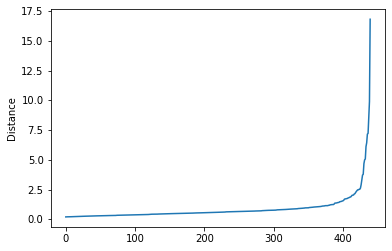

In [43]:
min_sample = 6 + 1

neigh = NearestNeighbors(n_neighbors=min_sample + 1)
neigh.fit(scaled_df)
distances, indices = neigh.kneighbors(scaled_df)

print(distances.shape)


plt.plot(np.sort(distances[:,min_sample]))
plt.ylabel("Distance")

min_sample = np.log(scaled_df.shape[0])

# epsilon의 범위 0.5 ~ 2.5

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


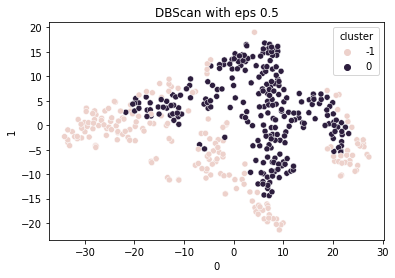

Silhouette Coefficient: 0.2281
---------------------
Davies Bouldin Index: 1.8678


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


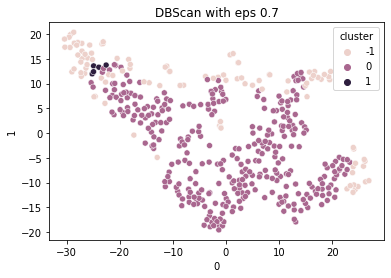

Silhouette Coefficient: 0.2392
---------------------
Davies Bouldin Index: 1.8909


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


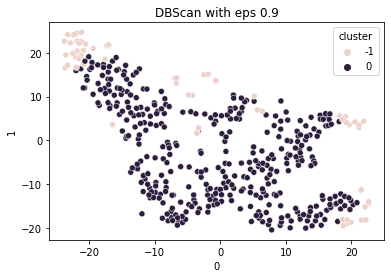

Silhouette Coefficient: 0.5148
---------------------
Davies Bouldin Index: 1.8255


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


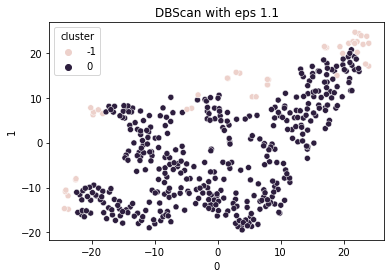

Silhouette Coefficient: 0.5744
---------------------
Davies Bouldin Index: 1.6583


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


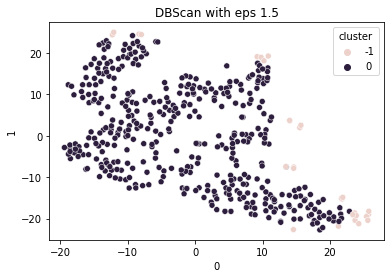

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Silhouette Coefficient: 0.6468
---------------------
Davies Bouldin Index: 1.5103


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


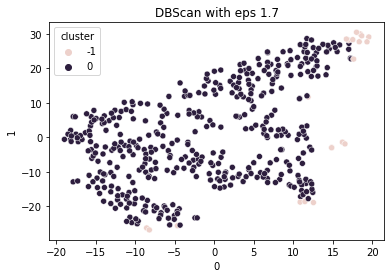

Silhouette Coefficient: 0.6967
---------------------
Davies Bouldin Index: 1.4258


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


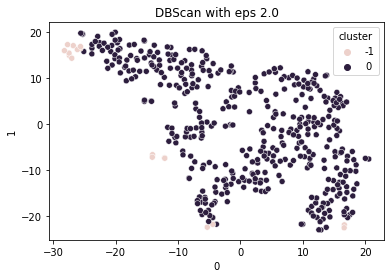

Silhouette Coefficient: 0.7266
---------------------
Davies Bouldin Index: 1.3396


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


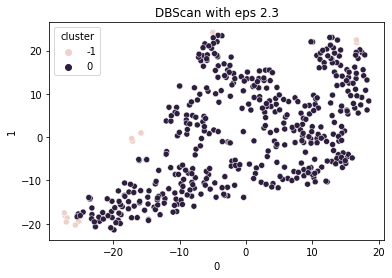

Silhouette Coefficient: 0.7487
---------------------
Davies Bouldin Index: 1.3683


In [44]:
# train = pd.DataFrame(pca_df)
from sklearn.manifold import TSNE

eps = [0.5,  0.7, 0.9, 1.1, 1.5, 1.7, 2.0, 2.3]

for i in eps:
    db = DBSCAN(eps=i, min_samples=7)
    cluster = db.fit(scaled_df)
    cluster_id = pd.DataFrame({"cluster":cluster.labels_})
    
    d = pd.concat([scaled_df, cluster_id],axis=1)

    tsne = TSNE(n_components=2)
    df_tnse = pd.DataFrame(tsne.fit_transform(scaled_df), columns=[0, 1])

    sns.scatterplot(df_tnse[0], df_tnse[1], hue = d['cluster'], legend="full")
    plt.title('DBScan with eps {}'.format(i))
    plt.show()
    
    print('Silhouette Coefficient: {:.4f}'.format(silhouette_score(d.iloc[:,:-1], d['cluster'])))
    print('---------------------')
    print('Davies Bouldin Index: {:.4f}'.format(davies_bouldin_score(d.iloc[:,:-1], d['cluster'])))

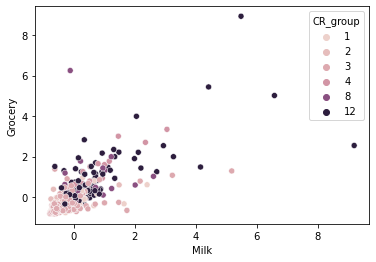

In [45]:
sns.scatterplot(data=scaled_df,x='Milk',y='Grocery',hue=df['CR_group'])
plt.grid(False)
plt.show()

In [46]:
new_df = pd.concat([df['CR_group'], scaled_df], axis=1)
new_df.head()

,CR_group,Delicassen,Detergents_Paper,Fresh,Frozen,Grocery,Milk
0,12,-0.066339,-0.043569,0.052933,-0.589367,-0.041115,0.523568
1,12,0.089151,0.086407,-0.391302,-0.270136,0.170318,0.544458
2,12,2.243293,0.133232,-0.447029,-0.137536,-0.028157,0.408538
3,3,0.093411,-0.498588,0.100111,0.687144,-0.392977,-0.624020
4,12,1.299347,-0.231918,0.840239,0.173859,-0.079356,-0.052396


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


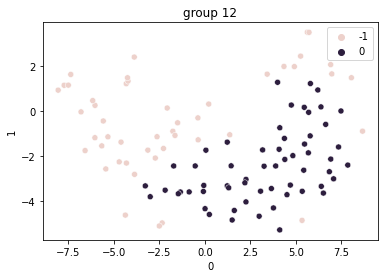

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


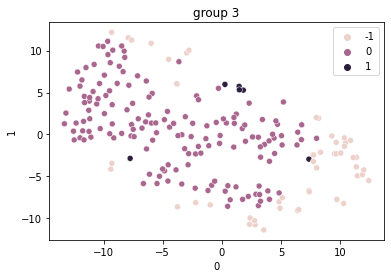

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


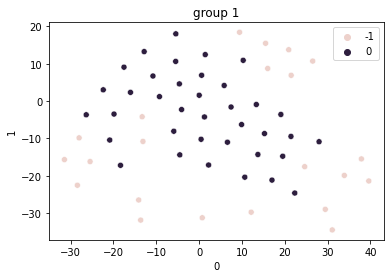

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


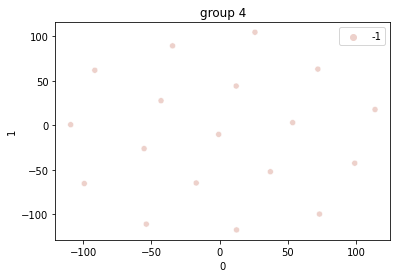

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


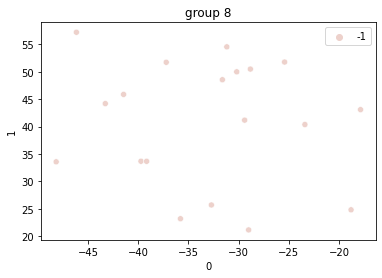

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


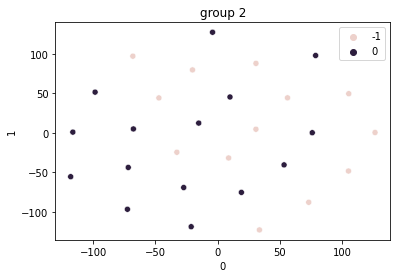

In [48]:
group = new_df['CR_group'].unique()

eps=0.7

for g in group:
    d = new_df[new_df['CR_group']==g].copy()
    d = d.drop(['CR_group'], axis=1)

    db = DBSCAN(eps=eps, min_samples=7)
    cluster = db.fit(d)

    tsne = TSNE(n_components=2)
    df_tnse = pd.DataFrame(tsne.fit_transform(d), columns=[0, 1])

    sns.scatterplot(df_tnse[0], df_tnse[1], hue = cluster.labels_, legend="full")
    plt.title('group {}'.format(g))
    plt.show()
  